# Introduction to Recurrent Neural Networks 

Classical neural networks, including convolutional ones, suffer from two severe limitations:

+ They only accept a fixed-sized vector as input and produce a fixed-sized vector as output.
+ They do not consider the sequential nature of some data (language, video frames, time series, etc.) 

Recurrent neural networks overcome these limitations by allowing to operate over sequences of vectors (in the input, in the output, or both).

## Vanilla Recurrent Neural Network

+ We can think of the **hidden state** $s_t$ as a memory of the network that captures information about the previous steps.
+ The RNN **shares the parameters** $U,V,W$ across all time steps.


<img src="../../imgs/rnn_vanilla.png" alt="" style="width: 400px;"/>


## Unrolling in time of a RNN

By unrolling we mean that we write out the network for the complete sequence. Note that the state at time $t$ depends on current input $x_t$ and previsous state $s_{t-1}$.

$$ s_t = \mbox{tanh }(Ux_t + W s_{t-1}) $$
$$ y_t = \mbox{softmax }(V s_t) $$

<img src="../../imgs/rnn_unrolling.png" alt="" style="width: 600px;"/>
<img src="../../imgs/rnn_TanhReal.gif" alt="" style="width: 200px;"/>


## RNN inputs and ouputs

<img src="../../imgs/rnn_kar.png" alt="" style="width: 600px;"/>

Source: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

## RNN capabilities

From Karpahty's blog:


''RNNs combine the input vector with their state vector with a fixed (but learned) function to produce a new state vector. This can in programming terms be interpreted as running a fixed program with certain inputs and some internal variables. Viewed this way, RNNs essentially describe programs. In fact, **it is known that RNNs are Turing-Complete** in the sense that they can to simulate arbitrary programs (with proper weights).''

RNN have shown success in:

+ Language modeling and generation.
+ Machine Translation.
+ Speech Recognition.
+ Image Description.
+ Question Answering.
+ Time series analysis.
+ Session based recommender systems
+ Etc.

## RNN Training

Training a RNN is similar to training a traditional NN, but with some modifications. The main reason is that parameters are shared by all time steps: in order to compute the gradient at $t=4$, we need to propagate 3 steps and sum up the gradients. This is called **Backpropagation through time (BPTT)**. Thanks god, this is automatically handled by the optimizer =)

Recurrent neural networks propagate weight matrices from one time-step to the next. Recall the goal of a RNN implementation is to enable propagating context information through faraway time-steps. When these propagation results in a long series of matrix multiplications, **weights can vanish or explode**. 

Once the gradient value grows extremely large, it causes an overflow (i.e. ``NaN``) which is easily detectable at runtime; this issue is called the *Gradient Explosion Problem*. It is normally avoided by clipping gradients during training (use the parameter `clipnorm` in any optimizer), as introduced by [Thomas Mikolov](https://research.fb.com/people/mikolov-tomas/).

<img src="../../imgs/rnn_exploding.png" alt="" style="width: 400px;"/>

When the gradient value goes to zero, however, it can go undetected while drastically reducing the learning quality of the model for far-away words in the corpus; this issue is called the *Vanishing Gradient Problem*. This issue is avoided with better initialization schemmes (in Keras, the `kernel_initializer` is set to 'glorot_uniform' and the  `recurrent_initializer` to 'orthogonal', see the [documentation](https://keras.io/layers/recurrent/)). 

# Gated Units

The transition from hidden state $h_{t-1}$ to $h_{t}$ in vanilla RNN is defined by using an affine transformation and a point-wise nonlinearity. 

What motivates the use of gated units? Although RNNs can theoretically capture long-term dependencies, they are very hard to actually train to do this. **Gated recurrent units are designed** in a manner to have more persistent memory thereby making it easier for RNNs **to capture long-term dependencies**. 

The most important types of gated RNNs are:

+ Long Short Term Memories (LSTM). It was introduced by S.Hochreiter and J.Schmidhuber in 1997 and is widely used. LSTM is very good in the long run due to its high complexity.
+ Gated Recurrent Units (GRU). It was recently introduced by K.Cho. It is simpler than LSTM, fasters and optimizes quicker. 


#### LSTM

The key idea of LSTMs is the cell state $C$, the horizontal line running through the top of the diagram.

The cell state is kind of like a conveyor belt. It runs straight down the entire chain, with only some minor linear interactions. It’s very easy for information to just flow along it unchanged.

<img src="../../imgs/rnn_lstm.png" alt="Source: http://colah.github.io/posts/2015-08-Understanding-LSTMs/" style="width: 600px;"/> 

LSTM has the ability to remove or add information to the cell state, carefully regulated by structures called gates.

Gates are a way to optionally let information through. They are composed out of a *sigmoid* neural net layer and a pointwise multiplication operation.

Let us see how a LSTM uses $h_{t-1}, C_{t-1}$ and $x_{t}$ to generate the next hidden states $C_t, h_{t}$:

$$ f_t = \sigma(W_f \cdot [h_{t-1}, x_t]) \mbox{ (Forget gate)} $$
$$ i_t = \sigma(W_i \cdot [h_{t-1}, x_t]) \mbox{ (Input gate)} $$
$$ \tilde C_t = \operatorname{tanh}(W_C \cdot [h_{t-1}, x_t]) $$
$$ C_t = f_t * C_{t-1} + i_t * \tilde C_t \mbox{ (Update gate)} $$
$$ o_t = \sigma(W_o \cdot [h_{t-1}, x_t]) $$
$$ h_t = o_t * \operatorname{tanh}(C_t) \mbox{ (Output gate)} $$

There are other variants of LSTM (f.e. LSTM with peephole connections of Gers & Schmidhuber (2000))

#### GRU

<img src="../../imgs/rnn_gru.png" alt="Source: http://colah.github.io/posts/2015-08-Understanding-LSTMs/" style="width: 300px;"/> 

Let us see how a GRU uses $h_{t-1}$ and $x_{t}$ to generate the next hidden state $h_{t}$.

$$ z_{t} = \sigma(W_z \cdot [x_{t}, h_{t-1}]) \mbox{ (Update gate)}$$
$$ r_{t} = \sigma(W_r \cdot [x_{t}, h_{t-1}]) \mbox{ (Reset gate)}$$
$$ \tilde{h}_{t} = \operatorname{tanh}(r_{t} \cdot  [x_{t}, r_t \circ h_{t-1}]   ) \mbox{ (New memory)}$$
$$ h_{t} = (1 - z_{t}) \circ \tilde{h}_{t-1} + z_{t} \circ h_{t} \mbox{ (Hidden state)}$$

It combines the forget and input gates into a single “update gate.” It also merges the cell state and hidden state, and makes some other changes. The resulting model is simpler than standard LSTM models.

# Example: Learning to predict a sequence from another sequence

The proposed task is to predict a signal (e.g., a cosine) out of phase from the original signal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM, GRU
from keras import losses
import keras.backend as K

Using TensorFlow backend.


In [2]:
f = lambda x: (np.cos(x)**2 + np.sin(x))/2.0
nb_samples = 5000 

phase = -np.pi / 4.0
x = np.linspace(-5*np.pi, 5*np.pi, nb_samples)
x_train = f(x)
y_train = f(x+phase)

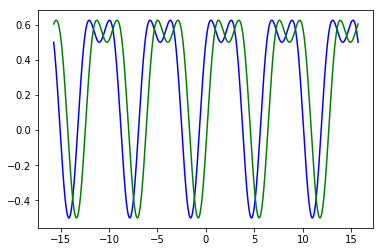

In [3]:
plt.plot(x, x_train, 'b')
plt.plot(x, y_train, 'g')
plt.show()

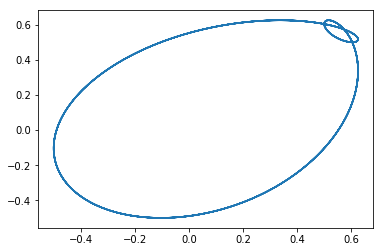

In [4]:
plt.plot(x_train, y_train);

## Handling sequences with RNNs

Whenever you train or test your LSTM/GRU, you first have to build your input matrix $X$ of shape ``nb_samples``, ``timesteps``, ``input_dim`` where your batch size divides ``nb_samples``. 

For instance, if ``nb_samples=1024`` and ``batch_size=64``, it means that your model will receive blocks of 64 samples, compute each output (whatever the number of timesteps is for every sample), average the gradients and propagate it to update the parameters vector. 

> By default, **Keras shuffles (permutes) the samples in $X$** and the dependencies between $X_i$ and $X_{i+1}$ are lost. 

With the stateful model, all the states are propagated to the next batch. It means that the state of the sample located at index $i$, $X_i$, will be used in the computation of the sample $X_{i+bs}$ in the next batch, where $bs$ is the batch size (no shuffling).

> Keras requires the batch size in ``stateful`` mode and ``shuffle=False``.

In statefull mode, you have to restart the internal state of the cell after each epoch. In stateless mode this is done after each batch.

In [5]:
batch_size = 25
tsteps = 1
input_dim = 1
# Give x_train the shape required by the RNN
x_train_rnn = np.reshape(x_train, newshape=(nb_samples, tsteps, input_dim))

In [6]:
epochs = 30

K.clear_session()
print('Creating Model')
model = Sequential()
model.add(LSTM(50,
               batch_input_shape=(batch_size, tsteps, input_dim),
               return_sequences=True,
               stateful=True))
model.add(LSTM(50,
               return_sequences=False,
               stateful=True))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Creating Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (25, 1, 50)               10400     
_________________________________________________________________
lstm_2 (LSTM)                (25, 50)                  20200     
_________________________________________________________________
dense_1 (Dense)              (25, 1)                   51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


Training
Epoch 0 / 30
Epoch 1/1
5000/5000 [==============================] - 2s 388us/step - loss: 0.0193
Epoch 1 / 30
Epoch 1/1
5000/5000 [==============================] - 1s 173us/step - loss: 0.0061
Epoch 2 / 30
Epoch 1/1
5000/5000 [==============================] - 1s 181us/step - loss: 0.0055
Epoch 3 / 30
Epoch 1/1
5000/5000 [==============================] - 1s 181us/step - loss: 0.0052
Epoch 4 / 30
Epoch 1/1
5000/5000 [==============================] - 1s 166us/step - loss: 0.0049
Epoch 5 / 30
Epoch 1/1
5000/5000 [==============================] - 1s 167us/step - loss: 0.0047
Epoch 6 / 30
Epoch 1/1
5000/5000 [==============================] - 1s 177us/step - loss: 0.0045
Epoch 7 / 30
Epoch 1/1
5000/5000 [==============================] - 1s 171us/step - loss: 0.0043
Epoch 8 / 30
Epoch 1/1
5000/5000 [==============================] - 1s 174us/step - loss: 0.0042
Epoch 9 / 30
Epoch 1/1
5000/5000 [==============================] - 1s 165us/step - loss: 0.0041
Epoch 10 / 30
Epoch 1

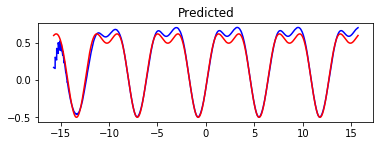

In [7]:
print('Training')
for i in range(epochs):
    print('Epoch', i, '/', epochs)
    model.fit(x_train_rnn,
              y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=1,
              shuffle=False)
    model.reset_states()

print('Predicting')
predicted_output = model.predict(x_train_rnn, batch_size=batch_size)
err = np.mean((y_train-predicted_output)**2)
print("Error in reconstruction is %0.2f" % err)
print('Ploting Results')
plt.subplot(2, 1, 1)
plt.plot(x, predicted_output, 'b', x, y_train, 'r')
plt.title('Predicted')
plt.show()    

# Do the same with a GRU Cell

Creating Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (25, 1, 50)               7800      
_________________________________________________________________
gru_2 (GRU)                  (25, 50)                  15150     
_________________________________________________________________
dense_1 (Dense)              (25, 1)                   51        
Total params: 23,001
Trainable params: 23,001
Non-trainable params: 0
_________________________________________________________________
Training
Epoch 0 / 30
Epoch 1/1
5000/5000 [==============================] - 1s 259us/step - loss: 0.0120
Epoch 1 / 30
Epoch 1/1
5000/5000 [==============================] - 1s 150us/step - loss: 0.0061
Epoch 2 / 30
Epoch 1/1
5000/5000 [==============================] - 1s 149us/step - loss: 0.0059
Epoch 3 / 30
Epoch 1/1
5000/5000 [==============================] - 1s 148us/step - los

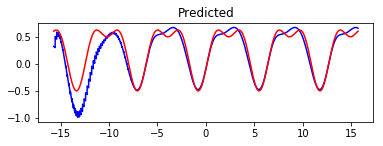

In [8]:
epochs = 30

K.clear_session()
print('Creating Model')
model = Sequential()
model.add(GRU(50,
               batch_input_shape=(batch_size, tsteps, input_dim),
               return_sequences=True,
               stateful=True))
model.add(GRU(50,
               return_sequences=False,
               stateful=True))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()
print('Training')
for i in range(epochs):
    print('Epoch', i, '/', epochs)
    model.fit(x_train_rnn,
              y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=1,
              shuffle=False)
    model.reset_states()

print('Predicting')
predicted_output = model.predict(x_train_rnn, batch_size=batch_size)
err = np.mean((y_train-predicted_output)**2)
print("Error in reconstruction is %0.2f" % err)
print('Ploting Results')
plt.subplot(2, 1, 1)
plt.plot(x, predicted_output, 'b', x, y_train, 'r')
plt.title('Predicted')
plt.show()    